In [18]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD, NMF, PCA

np.random.seed(42)
random.seed(42)

In [ ]:
# QUESTION 7: Dimensionality Reduction

DATA_PATH = "Project1-ClassificationDataset.csv"
df = pd.read_csv(DATA_PATH)

df = df[["full_text", "root_label", "leaf_label"]].copy()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

train_texts = train_df["full_text"].astype(str).tolist()
test_texts  = test_df["full_text"].astype(str).tolist()

Train size: (2780, 3)
Test size: (696, 3)


In [ ]:
# similar to Q3
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"", texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u ', " you ", texter)
    texter = re.sub('`', "", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ', texter)
    cleaner = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(cleaner, '', texter)
    if texter == "":
        texter = ""
    return texter

train_texts_clean = [clean(t) for t in train_texts]
test_texts_clean  = [clean(t) for t in test_texts]

import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download('averaged_perceptron_tagger_eng')
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()

def _to_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

_num_like = re.compile(r"^[+-]?(\d+(\.\d*)?|\.\d+)$")

def lemma_tokenizer(text: str):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    lemmas = []
    for w, tag in tagged:
        if _num_like.match(w):
            continue

        if not any(ch.isalpha() for ch in w):
            continue

        wn_pos = _to_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(w, pos=wn_pos))
    return lemmas

count_vec = CountVectorizer(
    stop_words="english",
    tokenizer=lemma_tokenizer,
    min_df=3
)

X_train_counts = count_vec.fit_transform(train_texts_clean)
X_test_counts  = count_vec.transform(test_texts_clean)

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_tfidf  = tfidf.transform(X_test_counts)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape :", X_test_tfidf.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.

TF-IDF train shape: (2780, 14250)
TF-IDF test shape : (696, 14250)


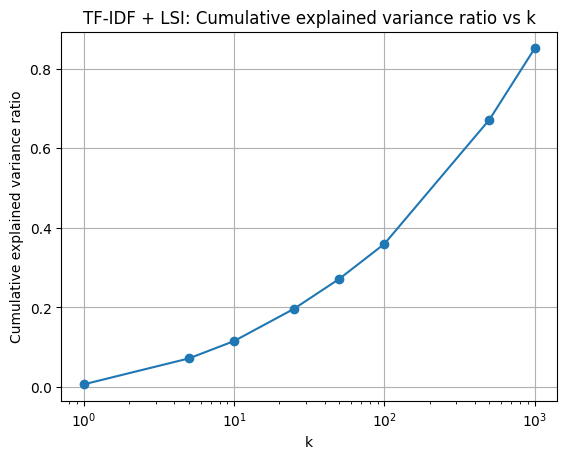

LSI (k=25) train shape: (2780, 25)
LSI (k=25) test shape : (696, 25)


In [ ]:
# 7. a)

k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
max_k = X_train_tfidf.shape[1] - 1

explained_variance_ratio = []
valid_k = []

for k in k_values:
    if k > max_k:
        continue

    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train_tfidf)

    explained_variance_ratio.append(svd.explained_variance_ratio_.sum())
    valid_k.append(k)

plt.figure()
plt.plot(valid_k, explained_variance_ratio, marker="o")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("Cumulative explained variance ratio")
plt.title("TF-IDF + LSI: Cumulative explained variance ratio vs k")
plt.grid(True)
plt.show()

k = 25

svd_25 = TruncatedSVD(n_components=k, random_state=42)
X_train_lsi_25 = svd_25.fit_transform(X_train_tfidf)
X_test_lsi_25  = svd_25.transform(X_test_tfidf)

print(f"LSI k={k} train shape:", X_train_lsi_25.shape)
print(f"LSI k={k} test shape:", X_test_lsi_25.shape)

In [ ]:
# 7. b)

def get_reconstruction_mse(X, X_hat):
    n, m = X.shape
    X_frob_sq = float(np.sum(X.data ** 2))
    Xhat_frob_sq = float(np.sum(X_hat ** 2))
    X_coo = X.tocoo()
    inner_prod = float(np.sum(X_coo.data * X_hat[X_coo.row, X_coo.col]))
    frob_diff_sq = X_frob_sq + Xhat_frob_sq - 2.0 * inner_prod
    return frob_diff_sq / (n * m)

X_train_lsi_hat = X_train_lsi_25 @ svd_25.components_
X_test_lsi_hat  = X_test_lsi_25  @ svd_25.components_

mse_lsi_train = get_reconstruction_mse(X_train_tfidf, X_train_lsi_hat)
mse_lsi_test  = get_reconstruction_mse(X_test_tfidf,  X_test_lsi_hat)

print("k = 25\n")
print("LSI reconstruction MSE:")
print("  train:", mse_lsi_train)
print("  test :", mse_lsi_test, '\n')

nmf_25 = NMF(
    n_components=25,
    init="nndsvda",
    random_state=42,
    max_iter=400
)

W_train = nmf_25.fit_transform(X_train_tfidf)
W_test  = nmf_25.transform(X_test_tfidf)
H = nmf_25.components_

print("NMF train shape:", W_train.shape)
print("NMF test shape :", W_test.shape)

X_train_nmf_hat = W_train @ H
X_test_nmf_hat  = W_test  @ H

mse_nmf_train = get_reconstruction_mse(X_train_tfidf, X_train_nmf_hat)
mse_nmf_test  = get_reconstruction_mse(X_test_tfidf,  X_test_nmf_hat)

print("NMF reconstruction MSE:")
print("  train:", mse_nmf_train)
print("  test :", mse_nmf_test)

if mse_lsi_train < mse_nmf_train:
    smaller = "LSI"
else:
    smaller = "NMF"

print("\nSmaller reconstruction error:", smaller)
print(
    "LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error."
)


k = 25

LSI reconstruction MSE:
  train: 5.4628105866023575e-05
  test : 5.613464262285954e-05 

NMF train shape: (2780, 25)
NMF test shape : (696, 25)
NMF reconstruction MSE:
  train: 5.502233200703562e-05
  test : 5.635256116921431e-05

Smaller reconstruction error: LSI
LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.


In [20]:
# 7. c) optional
# based on either GLoVE or LLM embeddings